<a href="https://colab.research.google.com/github/tezike/fastbook-notes/blob/master/Fastbook_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Personal explanation of concepts introduce in lesson 4 of fastai's fastbook

## Training a Digit Classifier(No neural Network)

We'll be training a digit classifier using the popular MNIST dataset containing handwritten numbers from 0-9. This dataset was curated by Yann Le-Cun who is considered as one of the founding fathers of nueral networks

In [1]:
!pip -q install fastai2

     |████████████████████████████████| 184kB 4.9MB/s 


In [0]:
from fastai2.vision.all import *

When faced with a deep learning probelm, it is always good to use a small subset of the data to try out different idea that you may have and then when satisfied, you can scale it up to the larger task at hand.

Thankfully, fastai have curated a smaller sample of the Mnist dataset which has just 2 classes representing 3 and 7. They can be found in fastai's `URLs` class

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/valid')]

In [4]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/7'),Path('/root/.fastai/data/mnist_sample/train/3')]

We can take all the images in each of these classes and put them in an `L` list object

In [5]:
threes = (path/'train/3').ls()
sevens = (path/'train/7').ls()
len(threes), len(sevens)

(6131, 6265)

We now have 2 lists containing 6131 images of threes and 6265 images of sevens. Just to confirm this claim, why don't we visualize one of the items of the list

In [93]:
img_3 = Image.open(threes[0])
img_3

NB: fastai uses the famous Pillow(PIL) library for loading, manipulating and viewing images. This return the image as a PILImage object. We can get the numbers that make up this image either as a numpy array or as a pytorch tensor by calling either the `array` or the `tensor` methods on the image

In [95]:
array(img_3)[4:10, 4:10] #looking at top left corner

array([[  0,   0,   0,   0,   0,   0],
       [  0,  20, 146, 146, 197, 254],
       [  0, 114, 253, 253, 253, 253],
       [  0, 114, 253, 253, 253, 253],
       [  0,  49, 236, 253, 253, 227],
       [  0,   0,  39,  99, 122,  25]], dtype=uint8)

In [96]:
tensor(img_3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,  20, 146, 146, 197, 254],
        [  0, 114, 253, 253, 253, 253],
        [  0, 114, 253, 253, 253, 253],
        [  0,  49, 236, 253, 253, 227],
        [  0,   0,  39,  99, 122,  25]], dtype=torch.uint8)

A handy trick that was show in the book is how to visualize the pixel representations by using a dataframe

In [107]:
tensor_img_3 = tensor(img_3)[3:25, 2:25]
df = pd.DataFrame(tensor_img_3)
df.style.set_properties(**{'font-size':'4pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,20,146,146,197,254,254,254,255,255,245,146,91,33,0,0,0,0,0,0,0
3,0,0,0,114,253,253,253,253,253,253,253,253,253,253,227,243,184,64,0,0,0,0,0
4,0,0,0,114,253,253,253,253,253,253,253,253,253,253,253,253,253,241,7,0,0,0,0
5,0,0,0,49,236,253,253,227,210,229,219,253,253,253,253,253,253,253,113,0,0,0,0
6,0,0,0,0,39,99,122,25,0,28,14,65,65,135,238,253,253,253,113,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,8,161,253,253,253,113,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,39,105,221,253,253,253,253,92,0,0,0,0
9,0,0,0,0,0,0,0,0,0,6,110,241,253,253,253,253,253,181,3,0,0,0,0


Voila! we can see how the pixel intensity at each position of the image affects the final image.
NB: Pixel intensities for images starts from 0(representing white) to 255 (representing black) for greyscale images

NOw that we've gotten an intuitive sense of how images are composed based on their pixels, how do we then tell if 2 images are similar or not using this our new found knowlegde.

One thing that we could do is to obtain and ideal 3 and an ideal 7 image. This can be gotten by taking the average of every pixel location of the image across all the images in the list of 3 images and 7 images respectively. This will give us the average intensity of a pixel at a particular pixel location from all the averaged images on the ideal image.

In [122]:
three_tensors = [tensor(Image.open(img)) for img in threes]
seven_tensors = [tensor(Image.open(img)) for img in sevens]
len(three_tensors), len(seven_tensors)

(6131, 6265)

So far we have a list containing tensors of 3 and 7. We really can average every pixel location of each of these lists because the images are seperated from each other. We need a way to stack them all up to be a giant lego of 3 images and 7 images. Pytorch has a method `stack` which does exaclty this. Normalize the tensors in the stack by converting them to float and dividing by 255 to limit thier pixel values to fall between 0 and 1

In [124]:
stacked_3 = torch.stack(three_tensors)/255.
stacked_7 = torch.stack(seven_tensors)/255.
stacked_3.shape, stacked_7.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

As you can see, we now have 6131 28X28 normalized images of 3s and 6265 28X28 normalized images of 7s. We can easily average this now to get a single 28X28 image for each class(7 and 3)

In [126]:
ideal_3 = stacked_3.float().mean(0)
ideal_7 = stacked_7.float().mean(0)
ideal_3.shape, ideal_7.shape

(torch.Size([28, 28]), torch.Size([28, 28]))

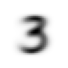

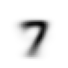

In [138]:
show_image(ideal_3, cmap='Greys'), show_image(ideal_7, cmap='Greys');

#####SIDEBAR: Let's talk about MATRIX RANKS:

The rank of a matrix tell us the number of axis or dimensions which the matrix or tensor has. I typically use the len of the output gotten after every `.shape` call on a tensor to know my rank.

In [144]:
stacked_3.shape, f'Lenght is:{len(stacked_3.shape)}'

(torch.Size([6131, 28, 28]), 'Lenght is:3')

We can also use the ndim method to get this rank

In [145]:
stacked_3.ndim

3

#####END

Now that we have the ideal 3 and 7, remember our goal is to be able to compare any arbitrary number to this ideal numbers to be able to tell which one is most similar to the ideal 3 or ideal 7. 
The bifg question on your mind now should be How do we go about calculating similarity between two numbers. Well, one way we can do this by calculating the distance between the pixels of the arbitrary numbe we are given and each of the ideal numbers and then check to see the one with the smallest distance. The one with the smallest distance is then assumed to fall under the ideal number's category'

Okay We have to calculate distance between pixels two tensors so we can just subtract the pixel values from each other right? WRONG! Turns out that is we do this we may end up with negative distances which may end up messing up with the overall distance. Thankfully there are 2 ways out of this challenge;
We can calculate distance by 
- Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or L1 norm
- Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm

These ensure that we do not have negative distances. Let's try it out!

In [150]:
mean_abs_dist_3 = (stacked_3[0] - ideal_3).abs().mean()
root_mean_sqr_dist_3 = ((stacked_3[0] - ideal_3)**2).mean().sqrt()
mean_abs_dist_3, root_mean_sqr_dist_3

(tensor(0.1485), tensor(0.2666))

In [151]:
mean_abs_dist_3 = (stacked_3[0] - ideal_7).abs().mean()
root_mean_sqr_dist_3 = ((stacked_3[0] - ideal_7)**2).mean().sqrt()
mean_abs_dist_3, root_mean_sqr_dist_3

(tensor(0.2015), tensor(0.3614))

As we can see, for the two distance measures, the `stacked_3[0]` is closer to the ideal_3